# SteadierCom simulations

In [1]:
import pandas as pd
import reframed
import os
import json
import numpy as np
from matplotlib import pyplot as plt
import re
import sys
sys.path.append('../functions')

import translation_dicts
import general_functions as general_func
import colors_community as color_func

import steadiercom_data_processing as steadier_data_func

from steadiercom import steadiercom

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
compounds_dict, source_dict,substrate_dict, gas_sheet_dict, community_dict = translation_dicts.translation_dicts()

### Load data

In [4]:
all_mags_paper = general_func.read_allmags_data()

with open('../output/community_production.json') as f:
    community_production = json.load(f)

top_99 = pd.read_csv("../output/steadiercom_sample_0.1.3/communities_top99.tsv",sep="\t",header=None)
top_99.set_index(1,inplace=True)
top_99.index.name="MAG"
top_99.columns = ["community"]

media_db = pd.read_csv("../output/steadiercom_sample_0.1.3/media_db.tsv",sep="\t")
media_db.set_index("medium",inplace=True)

met_chebi_class = pd.read_csv("../output/met_chebi_class.tsv",index_col=0,sep="\t")

**Define interesting classes**

In [5]:
interesting_super_classes = list(met_chebi_class["self defined super class"].unique())
interesting_super_classes.remove("other")
interesting_super_classes.remove("aromatic compounds")
interesting_super_classes.remove("organophosphorus compounds")
interesting_super_classes.remove("organosulfur compounds")
interesting_super_classes.remove("organonitrogen compounds")
interesting_super_classes.remove("minerals and atoms")

chebi_interesting = met_chebi_class[met_chebi_class["self defined super class"].isin(interesting_super_classes)]

### Load models

**Load universal model**

In [7]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

In [8]:
GEMs_dict = {}

directory = os.fsencode("../output/GEMs/GEMs_final/")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    print(filename)
    if filename.endswith(".xml"):
        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("../output/GEMs/GEMs_final/"+filename,flavor="bigg")


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

In [9]:
community_GEMs = {}
for community,MAGs in top_99.groupby("community").groups.items():
    
    community_GEMs[community]=[]
    for MAG in MAGs:
        reframed.Environment.empty(GEMs_dict[MAG],inplace=True)
        community_GEMs[community].append(GEMs_dict[MAG])

### Process other data

In [10]:
medias = {}

for media in set(media_db["compound"].index):
    
    medias[media] = media_db[media_db.index==media].compound.values


**Ensure that carbon is limiting**

In [32]:
community_media = {}

for community_id in community_GEMs.keys():
    
    if community_id in ["CM_A","CM_P","M_A","M_P"]:
        community_media[community_id] = reframed.Environment.from_compounds(medias["SC2_C"])
        #community_media[community_id].R_EX_glc__D_e = (-1/10,0)
        community_media[community_id].R_EX_cellb_e = (-1/20,0)
        community_media[community_id].R_EX_cell3_e = (-1/30,0)
        community_media[community_id].R_EX_cell4_e = (-1/40,0)
        community_media[community_id].R_EX_cell5_e = (-1/50,0)
        
       
    
    elif community_id.split("_")[1]=="X":
        community_media[community_id] = reframed.Environment.from_compounds(medias["SC1_X"])
        community_media[community_id].R_EX_xyl__D_e=((-6/50),0)
        community_media[community_id].R_EX_xylb_e=((-6/100),0)
        community_media[community_id].R_EX_xyl3_e=((-6/150),0)
        community_media[community_id].R_EX_xylan4_e=((-6/260),0)
        community_media[community_id].R_EX_xylan8_e=((-6/520),0)
        community_media[community_id].R_EX_ascb__L_e = (-1e-3,0)
        

    elif (community_id.split("_")[1]=="P") or (community_id.split("_")[1]=="A"):
        community_media[community_id] = reframed.Environment.from_compounds(medias["SC1_C"])
        #community_media[community_id].R_EX_glc__D_e = (-1/10,0)
        community_media[community_id].R_EX_cellb_e = (-1/20,0)
        community_media[community_id].R_EX_cell3_e = (-1/30,0)
        community_media[community_id].R_EX_cell4_e = (-1/40,0)
        community_media[community_id].R_EX_cell5_e = (-1/50,0)
        community_media[community_id].R_EX_ascb__L_e = (-1e-3,0)
       
    else:
        continue

    community_media[community_id].R_EX_so4_e = (-10,0)
    community_media[community_id].R_EX_cys__L_e = (-1e-3,1000)

In [33]:
relative_abundance_estimate = {}

for MAG in GEMs_dict.keys():
    relative_abundance_estimate["_".join(re.split("[-.]",MAG))] = all_mags_paper.loc[MAG,"new_coverage"]/100


### SteadierCom

- w_R = protein fraction allocated to ribosomal proteins per unit of growth rate. 
    - Higher w_R means lower translation -> slower metabolism?
- w_E: w_i is the proteome fraction to be invested in a enzyme i. The sum of w_i across all enzymes is w_e.
    - Higher w_E means higher cost for enzymes.

In [34]:
#@jit
def determine_cross_feedding_community(community_id,community_GEMs_ver,relative_abundance_estimate):
    
    try:
        print(community_id)
        community_model = reframed.Community(community_id,community_GEMs_ver[community_id])
        community_media[community_id].apply(community_model.merged_model,inplace=True,exclusive=True,warning=False)

        # estimate the abundance
        estimate_abundance = {model.id:relative_abundance_estimate[model.id] for model in community_GEMs_ver[community_id]}
        print("estimated_abundance: "+str(estimate_abundance))
        
        sol = steadiercom.SteadierCom(community_model,growth=0.0089, abundance=estimate_abundance,allocation=True,w_e=0.002,w_r=0.2)
        
        if sol.status.value=="Infeasible":
            sol = steadiercom.SteadierCom(community_model, abundance=estimate_abundance,allocation=True,w_e=0.002,w_r=0.2)
           
        if sol.status.value=="Infeasible":
            fitted_abundance = steadiercom.fit_abundance(community_model,growth=1e-2, abundance={model.id:relative_abundance_estimate[model.id] for model in community_GEMs[community_id]},allocation=True)
            sol = steadiercom.SteadierCom(community_model, abundance=fitted_abundance,allocation=True,w_e=0.002,w_r=0.2)
        

        print(str(sol)+"\n")
        
        sol_df = pd.DataFrame(sol.cross_feeding())
        sol_df.columns=["donor","receiver","compound","rate","mass_rate"]

    except Exception as error:
        print("Unable to find solution for: "+community_id+"\n")
        print("Error: ", error)
        return sol,None
    
    return sol,sol_df

In [35]:
def determine_cross_feedding(community_GEMs_ver, community_media,relative_abundance_estimate):
    steadiercom_crossfeeding = {}
    steadiercom_sols = {}
    
    for community_id in community_GEMs_ver.keys():
        sol,sol_df = determine_cross_feedding_community(community_id,community_GEMs_ver,relative_abundance_estimate)
        steadiercom_crossfeeding[community_id]=sol_df
        steadiercom_sols[community_id]=sol
        
    return steadiercom_crossfeeding,steadiercom_sols
   

In [36]:
steadiercom_crossfeeding_conditions = {}
steadiercom_sols_conditions = {}

conditions = {"basic":[community_GEMs,community_media]}
    
for name,community_GEMs_data in conditions.items():

    steadiercom_crossfeeding,steadiercom_sols = determine_cross_feedding(conditions[name][0], conditions[name][1],relative_abundance_estimate=relative_abundance_estimate)
    
    steadiercom_crossfeeding_conditions[name]=steadiercom_crossfeeding
    steadiercom_sols_conditions[name]=steadiercom_sols
    
    steadiercom_crossfeeding_all =pd.concat(steadiercom_crossfeeding)
    steadiercom_crossfeeding_all.to_csv("../output/steadiercom_single_sim_0.1.3/steadiercom_crossfeeding_"+name+".tsv",sep="\t")
    
    steadier_com_production = {}
    for community_id, df in steadiercom_crossfeeding.items():
        community_exchange = df[df["receiver"].isna()]
        community_exchange = community_exchange[["compound","mass_rate"]].groupby("compound").sum().sort_values(by="mass_rate")

        steadier_com_production[community_id]=community_exchange

    steadier_com_production_all = pd.concat(steadier_com_production,axis=1).fillna(0)
    steadier_com_production_all.to_csv("../output/steadiercom_single_sim_0.1.3/steadier_com_production_"+name+"_g.tsv",sep="\t")



CD_A
estimated_abundance: {'CH13_bin_12': 0.36526676, 'CH13_bin_11': 0.10155789999999999, 'CH13_bin_4': 0.10043969999999999, 'CH13_bin_14': 0.09628596, 'CH13_bin_25': 0.066927886, 'CH13_bin_17': 0.047645993000000005, 'CH13_bin_0': 0.04455086, 'CH13_bin_1': 0.013032592999999999, 'CH13_bin_13': 0.011359399999999999, 'CH13_bin_2': 0.010196663}
Community growth: 0.008899999999999998
CH13_bin_12	0.42608447506727853
CH13_bin_11	0.11846751264866029
CH13_bin_4	0.117163129901048
CH13_bin_14	0.11231778309898491
CH13_bin_25	0.07807152551650924
CH13_bin_17	0.05557915512614459
CH13_bin_0	0.05196867570675145
CH13_bin_1	0.015202548261359692
CH13_bin_13	0.013250764964431045
CH13_bin_2	0.011894429708832364

CD_P
estimated_abundance: {'CH15_bin_0': 0.2391904, 'CH15_bin_23': 0.10319866, 'CH15_bin_1': 0.09591573, 'CH15_bin_7': 0.078568373, 'CH15_bin_8': 0.056932935999999996, 'CH15_bin_22': 0.055164204, 'CH15_bin_6': 0.04528497, 'CH15_bin_17': 0.044137535000000006, 'CH15_bin_16': 0.042533417, 'CH15_bin_13'

In [22]:
abundance_dict = {community:sol.abundance for community,sol in steadiercom_sols_conditions["basic"].items()}
abundance_dict = {(community,MAG):abundance for community,abundance_dict in abundance_dict.items() for MAG,abundance in abundance_dict.items()}

pd.Series(abundance_dict).to_csv("../output/steadiercom_single_sim_0.1.3/abundance.tsv",sep="\t")

# Results

## Cross feeding plots

In [23]:
steadiercom_crossfeeding_basic=pd.read_csv("../output/steadiercom_single_sim_0.1.3/steadiercom_crossfeeding_basic.tsv",sep="\t",index_col=(0,1))
steadiercom_crossfeeding_basic.dropna(inplace=True)
steadiercom_crossfeeding_basic

donor     receiver    compound      rate  mass_rate
CD_A 1    CH13_bin_4  CH13_bin_11      M_ac_e  0.015138   0.000894
     3   CH13_bin_14  CH13_bin_11      M_ac_e  0.024651   0.001455
     5   CH13_bin_25  CH13_bin_11      M_ac_e  0.016271   0.000961
     7   CH13_bin_17  CH13_bin_11      M_ac_e  0.012803   0.000756
     9    CH13_bin_0  CH13_bin_11      M_ac_e  0.021402   0.001264
...              ...          ...         ...       ...        ...
M_X  48    CH3_bin_0    CH3_bin_2  M_mal__L_e  0.074782   0.009877
     63    CH3_bin_2    CH3_bin_0    M_succ_e  0.074782   0.008680
     65    CH3_bin_0    CH3_bin_2     M_ura_e  0.002248   0.000252
     66    CH3_bin_0    CH3_bin_1     M_ura_e  0.000649   0.000073
     69    CH3_bin_1    CH3_bin_0  M_xylan4_e  0.023077   0.016652

[1312 rows x 5 columns]

In [24]:
cmap = color_func.cmap_community()

cmap_lut = dict(zip(steadiercom_crossfeeding_basic.index.get_level_values(0).unique(),cmap.colors))

In [25]:
from matplotlib import colors

In [26]:
import matplotlib.pyplot as plt

def plot_interractions(steadiercom_crossfeeding_basic,selected_compounds=True,fig_title=False):
    steady_com_count = steadiercom_crossfeeding_basic.reset_index().groupby(["level_0","compound"]).count()["mass_rate"]
    
    cmap_local = colors.ListedColormap([cmap_lut[community] for community in steadiercom_crossfeeding_basic.index.get_level_values(0).unique()])
    
    # Only allow members of selected categories to be involved (avoid minerals etc)
    if selected_compounds:
        steady_com_count = steady_com_count.reset_index()[steady_com_count.reset_index().compound.isin(chebi_interesting.index)].set_index(["level_0","compound"])
    steady_com_count.index.names = ("Community","Compound")
    
    
    #**Remove redundant information**
    compounds = steady_com_count.reset_index()["Compound"]
    compounds = compounds.map(lambda x: model_uni.metabolites[x].name)
    compounds = compounds.map(lambda x: x.split("C2H3O3")[0])
    compounds = compounds.map(lambda x: x.split("C5H6N2O2")[0])
    compounds = compounds.map(lambda x: x.split(" CO2")[0])
    compounds = compounds.map(lambda x: x.split("C4H8O2")[0])


    steady_com_count = steady_com_count.reset_index().drop("Compound",axis=1)
    steady_com_count["Compound"] = compounds
    steady_com_count.set_index(["Community","Compound"],inplace=True)
    

    # prepare dataframe for plot
    all_compounds = steady_com_count.reset_index().groupby("Compound").count()["mass_rate"]
    all_compounds=all_compounds[all_compounds>1].index ## NB only include exchanges that occur 1 time or more. 
    steady_com_count = steady_com_count.loc[(slice(None),list(all_compounds)),:]
    steady_com_count_for_plot = steady_com_count["mass_rate"].unstack(level=0).fillna(0)


    #Sort by the sum of the columns
    steady_com_count_for_plot = steady_com_count_for_plot.transpose()[steady_com_count_for_plot.sum(axis=1).sort_values().index].transpose()
    
    """
    communityid2name_dict = {"CD_A":"Compost digestate - Avicel",
    "CD_P":"Compost digestate - PASC",
    "CD_X":"Compost digestate - Xylan",
    "CM_A":"Cow manure - Avicel",
    "CM_P":"Cow manure - PASC",
    "CM_X":"Cow manure - Xylan",
    "M_P":"Marshland soil - PASC",
    "M_X":"Marshland soil - Xylan",
    }
    """

    steady_com_count_for_plot = steady_com_count_for_plot.transpose().reset_index()
    #steady_com_count_for_plot["Community"]=steady_com_count_for_plot["Community"].map(lambda x:communityid2name_dict[x])
    steady_com_count_for_plot = steady_com_count_for_plot.set_index("Community").transpose()

    ax = steady_com_count_for_plot.plot(kind="bar",figsize=(15,6),cmap=cmap_local,fontsize=12, rot=90)
    plt.legend(fontsize=10)
    plt.xlabel('Compound', fontsize=20)
    plt.title("# of interactions",fontsize=20)
    if fig_title:
        plt.savefig(fig_title,bbox_inches='tight')
    plt.show()

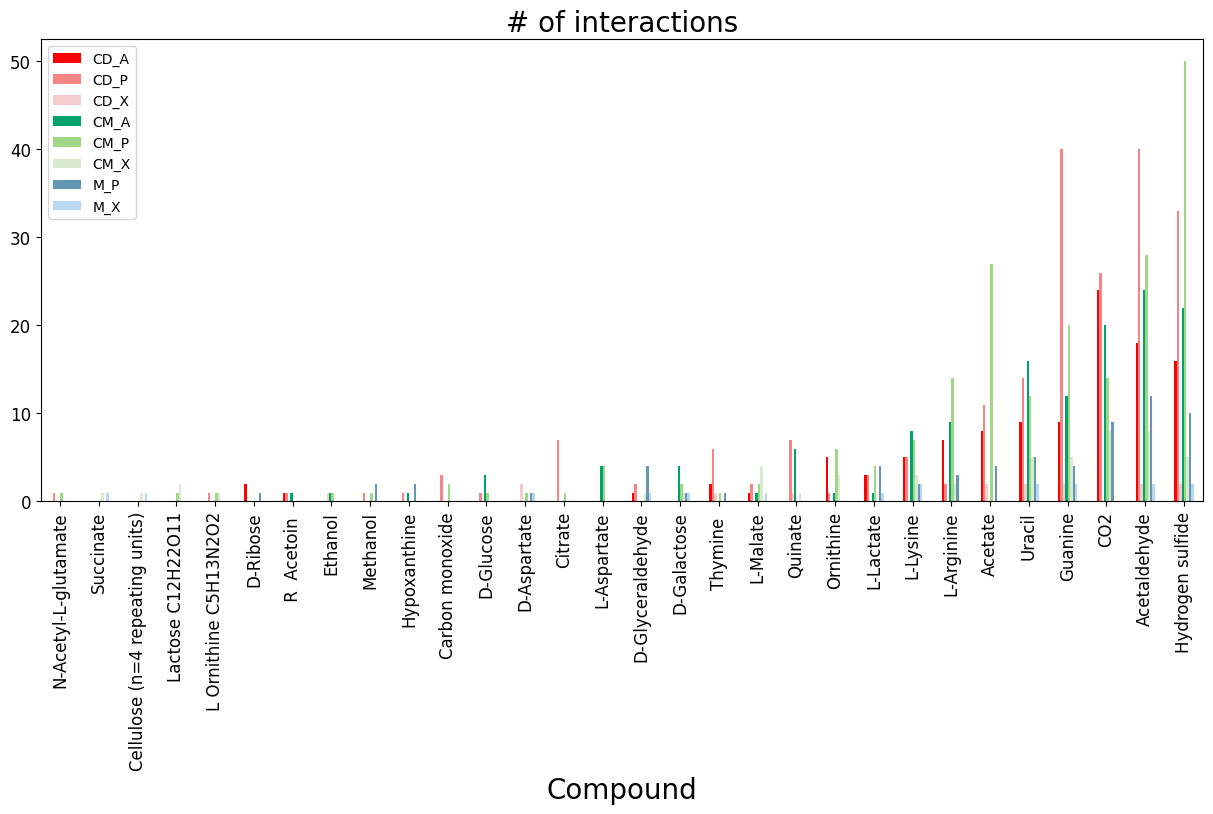

In [27]:
plot_interractions(steadiercom_crossfeeding_basic,selected_compounds=True)


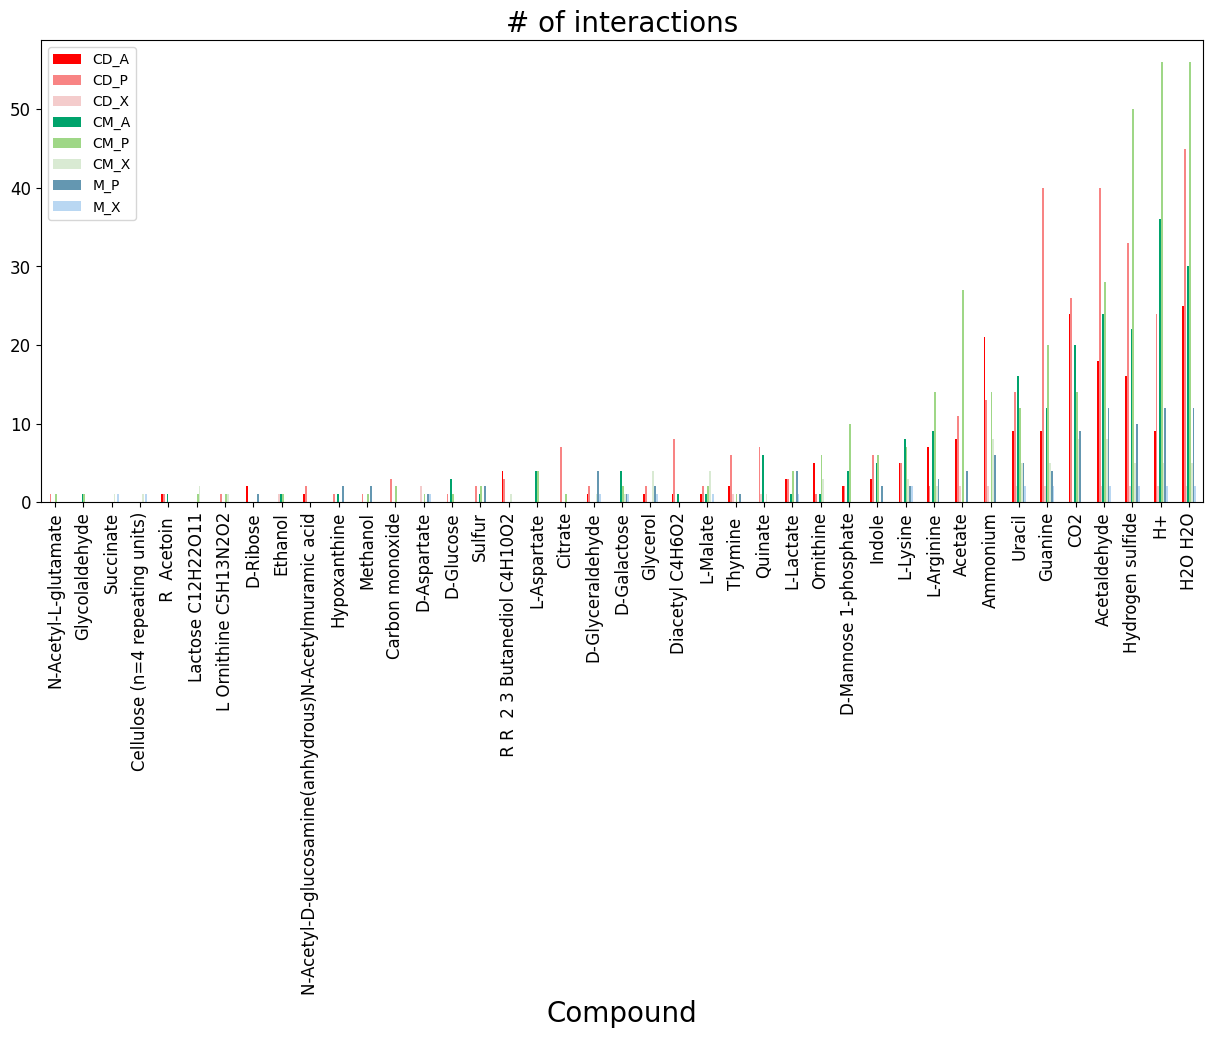

In [28]:
plot_interractions(steadiercom_crossfeeding_basic,selected_compounds=False)
#plt.savefig("all_interractions.png")

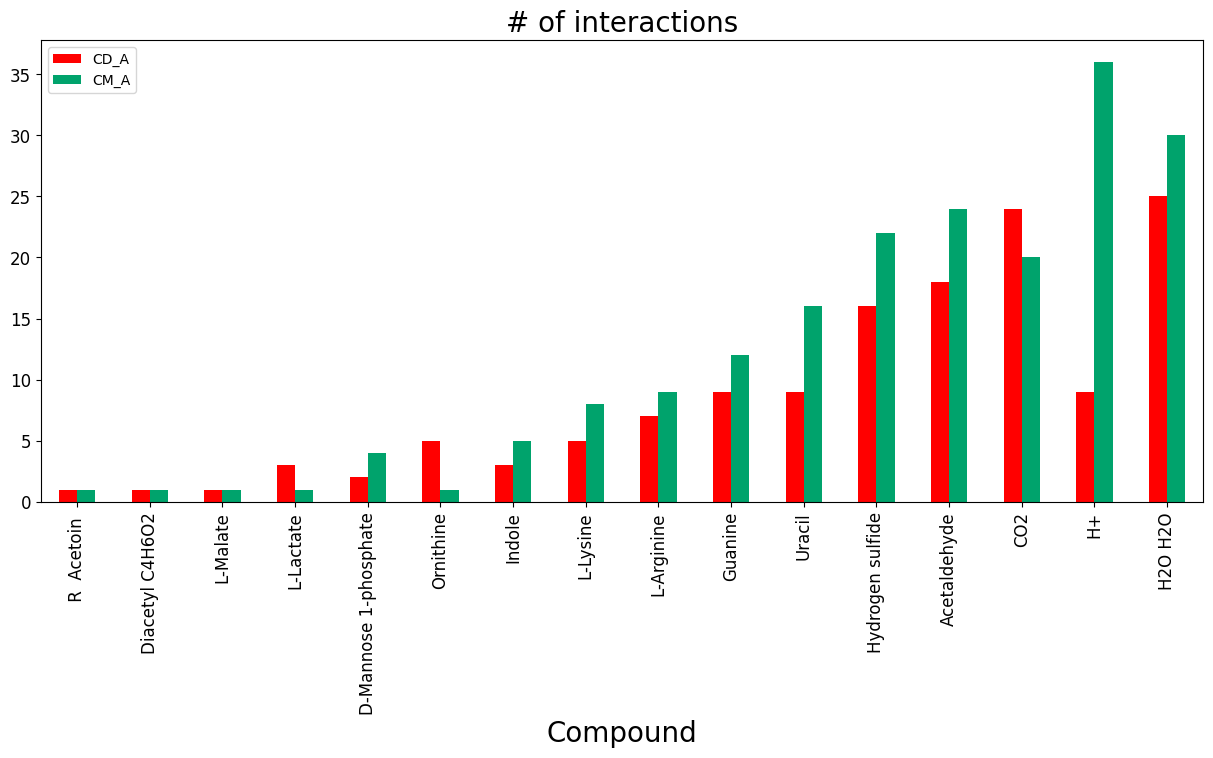

In [29]:
plot_interractions(steadiercom_crossfeeding_basic.loc[(["CD_A","CM_A"],slice(None)),:].copy(),selected_compounds=False)
#plt.savefig("Avicel_interractions.png")

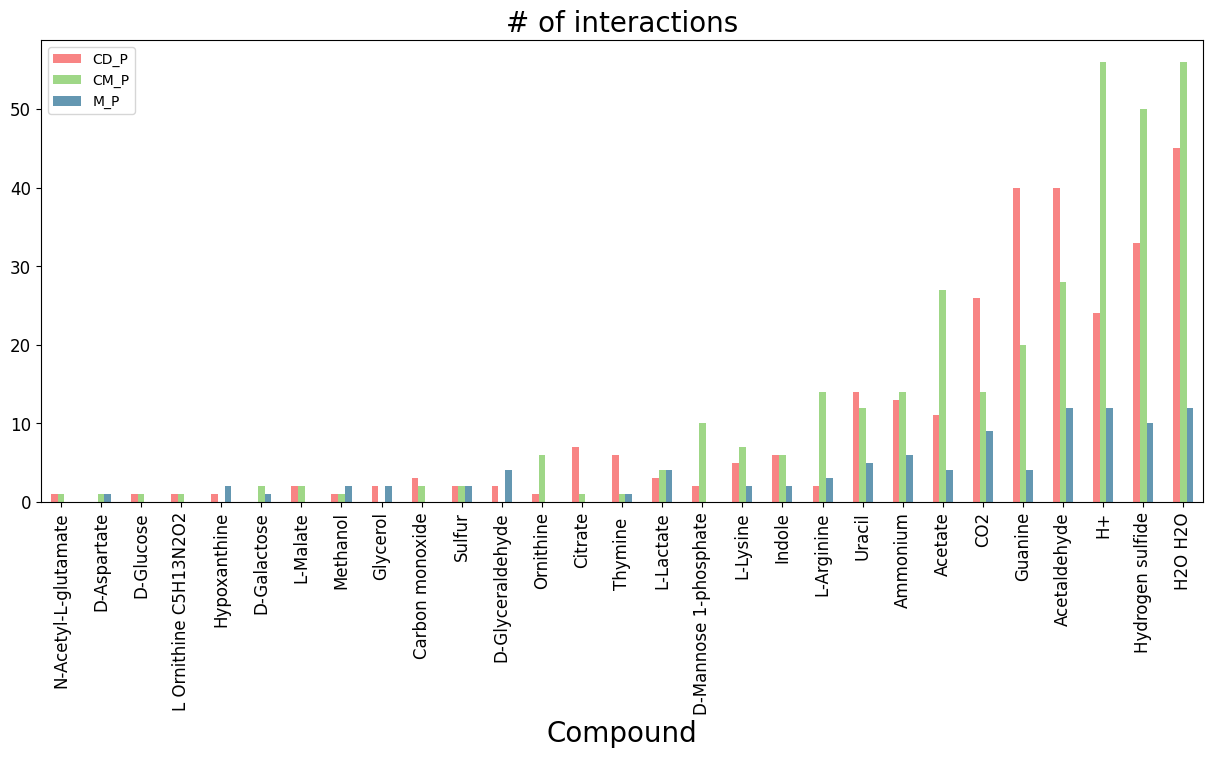

In [30]:
plot_interractions(steadiercom_crossfeeding_basic.loc[(["CD_P","CM_P","M_P"],slice(None)),:].copy(),selected_compounds=False)
#plt.savefig("PASC_interractions.png")

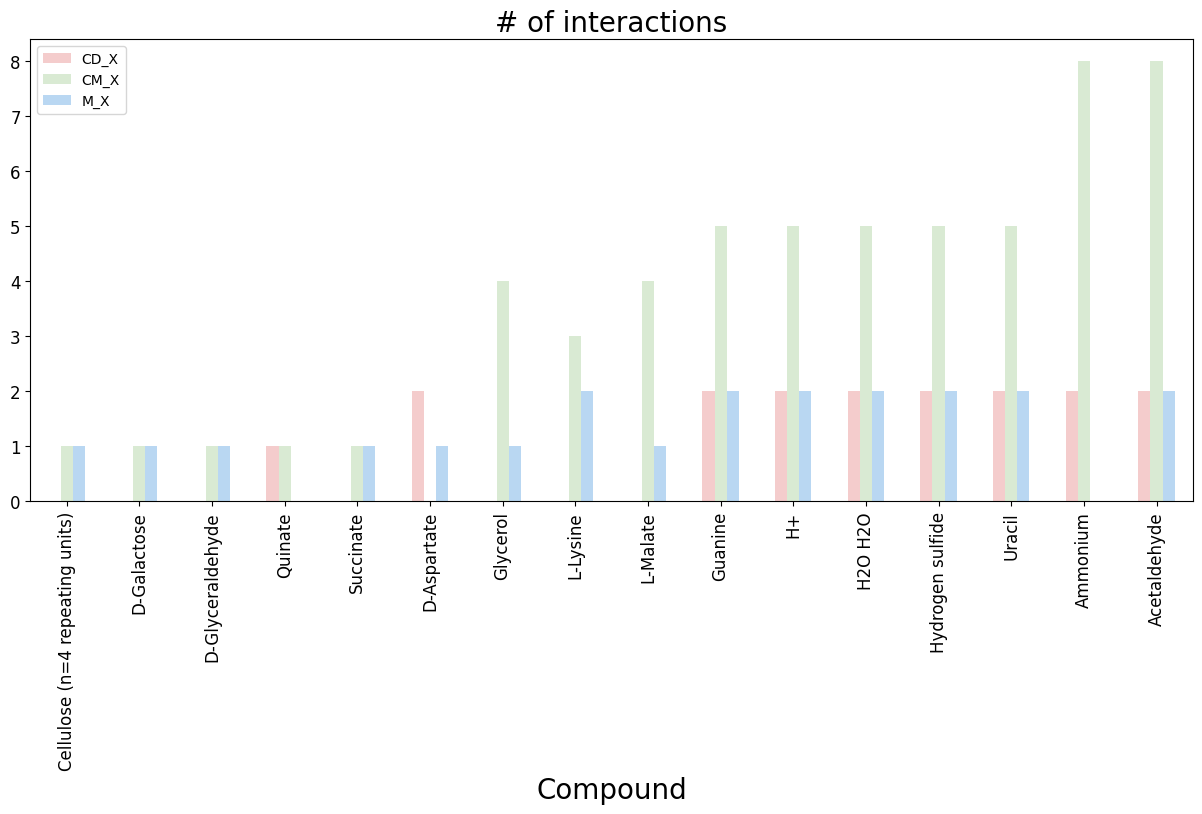

In [31]:
plot_interractions(steadiercom_crossfeeding_basic.loc[(["CD_X","CM_X","M_X"],slice(None)),:].copy(),selected_compounds=False)
#plt.savefig("xylan_interractions.png")

### Consumption plot 

In [ ]:
def production_consumption_plot(steadiercom_crossfeeding_basic,production=True,title=None):
    cmap_local = colors.ListedColormap([cmap_lut[community] for community in steadiercom_crossfeeding_basic.index.get_level_values(0).unique()])
   
    if production:
        steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic[steadiercom_crossfeeding_basic.receiver.isna()]
    else:
        steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic[steadiercom_crossfeeding_basic.donor.isna()]
        
    steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic.drop(["donor","receiver"],axis=1).set_index("compound",append=True).droplevel(1)
    steadiercom_crossfeeding_basic.index.names=["community","compound"]

    #**Remove redundant information**
    compounds = steadiercom_crossfeeding_basic.reset_index()["compound"]
    compounds = compounds.map(lambda x: model_uni.metabolites[x].name)
    compounds = compounds.map(lambda x: x.split("C2H3O3")[0])
    compounds = compounds.map(lambda x: x.split("C5H6N2O2")[0])
    compounds = compounds.map(lambda x: x.split(" CO2")[0])
    compounds = compounds.map(lambda x: x.split("C4H8O2")[0])

    steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic.reset_index().drop("compound",axis=1)
    steadiercom_crossfeeding_basic["compound"] = compounds

    
    steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic.reset_index().groupby(["community","compound"]).sum()["mass_rate"].unstack().fillna(0).transpose()
    steadiercom_crossfeeding_basic = steadiercom_crossfeeding_basic.transpose()[steadiercom_crossfeeding_basic.sum(axis=1).sort_values().index].transpose()
    ax = steadiercom_crossfeeding_basic.loc[steadiercom_crossfeeding_basic.sum(axis=1)>1e-10,:].plot(kind="bar",figsize=(20,10),cmap=cmap_local,ylabel="Flux rate [g/(h*g$_{bio}$)]",ylim=(0,0.05))
    return ax.get_figure()

In [ ]:
steadiercom_crossfeeding_basic=pd.read_csv("../output/steadiercom_single_sim_0.1.3/steadiercom_crossfeeding_basic.tsv",sep="\t",index_col=[0,1])


In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic,production=False)
#fig.savefig("figures_for_meeting/consumption_all.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_A","CM_A"],slice(None)),:].copy(),production=False)
#fig.savefig("figures_for_meeting/consumption_Avicel.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_P","CM_P","M_P"],slice(None)),:].copy(),production=False)
#fig.savefig("figures_for_meeting/consumption_PASC.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_X","CM_X","M_X"],slice(None)),:].copy(),production=False)
#fig.savefig("figures_for_meeting/consumption_Xylan.png",bbox_inches='tight')

## Production

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic,production=True)
#fig.savefig("figures_for_meeting/production_all.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_A","CM_A"],slice(None)),:].copy(),production=True)
#fig.savefig("figures_for_meeting/production_Avicel.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_P","CM_P","M_P"],slice(None)),:].copy(),production=True)
#fig.savefig("figures_for_meeting/production_PASC.png",bbox_inches='tight')

In [ ]:
fig = production_consumption_plot(steadiercom_crossfeeding_basic.loc[(["CD_X","CM_X","M_X"],slice(None)),:].copy(),production=True)
#fig.savefig("figures_for_meeting/production_Xylan.png",bbox_inches='tight')

## False positive/false negative

In [ ]:
steadier_com_production_basic = pd.read_csv("../output/steadiercom_single_sim_0.1.3/steadier_com_production_basic_g.tsv",index_col=0,sep="\t")
steadier_com_production_basic = steadier_com_production_basic.iloc[2:,:]
steadier_com_production_basic = steadier_com_production_basic.map(float)

In [ ]:
statistics = {}
TP_mets = {}



for type_,steadier_com_prod in {"no_manipulation":steadier_com_production_basic}.items():
    statistics[type_] = {}
    TP_mets[type_] = {}
    for community_id in steadier_com_prod.columns:
        statistics[type_][community_id]={}

        mets_sim = steadier_com_prod[community_id][steadier_com_prod[community_id]>1e-8]##NB Check cutoff value here. What is meassurable?
        mets_sim =[met.split("_")[1] for met in mets_sim.index.values]
        if "h" in mets_sim:
            mets_sim.remove("h")
            
        if "h2o" in mets_sim:
            mets_sim.remove("h2o")
        
        mets_exp = [string.split("_")[2] for string in community_production[community_id].keys()]

        TP = set(mets_exp).intersection(set(mets_sim))
        FP = set(mets_sim)-TP
        FN = set(mets_exp)-TP
        
        TP_mets[type_][community_id]=TP

        precision = len(TP)/(len(TP)+len(FP))
        sensitivity = len(TP)/(len(TP)+len(FN))

        statistics[type_][community_id]["precision"]=precision
        statistics[type_][community_id]["sensitivity"]=sensitivity

**Relatively high amount of false positive (low precision) and lower amount of false negative (higher sensitivity)**

In [ ]:
pd.DataFrame({(outerKey, innerKey): values for outerKey, innerDict in statistics.items() for innerKey, values in innerDict.items()}).transpose()

## How close are the community members to the protein constraints set?

1. Find sum of all fluxes. 
2. Compare with

$$\large \sum_i{v_i} < \frac{abundance(1 - \mu * w_r)}{w_e},$$

for each model

In [ ]:
steadiercom_crossfeeding_basic=pd.read_csv("../output/steadiercom_single_sim_0.1.3/steadiercom_crossfeeding_basic.tsv",sep="\t",index_col=(0,1))

phyla_groups,mag2phyla_dict,MAGs_steadycom_dict = steadier_data_func.find_members(steadiercom_crossfeeding_basic,all_mags_paper)

In [ ]:
CD_A = steadiercom_sols["CD_A"]

allocation_constraint_sim = {}

for community_member in CD_A.community.organisms.keys():
    community_member_fluxes = {rxn:value for rxn,value in steadiercom_sols["CD_A"].values.items() if (rxn.endswith(community_member) and "growth" not in rxn )}
    community_member_fluxes_enzymatic = {rxn:value for rxn,value in community_member_fluxes.items() 
                                         if GEMs_dict[MAGs_steadycom_dict[community_member]].reactions[rxn.replace("_"+community_member,"")].gpr is not None} # Check that GPR is not none

    sum_flux_all = pd.Series(community_member_fluxes).abs().sum()
    sum_flux_enzymatic = pd.Series(community_member_fluxes_enzymatic).abs().sum()
    
    abundance = CD_A.abundance[community_member]
    
    
    constraint_sum_flux = abundance*(1 - 0.0089*0.2)/0.002
    
    allocation_constraint_sim[community_member]={"sum_flux_all":sum_flux_all,"sum_flux_enzymatic":sum_flux_enzymatic,"constraint_sum_flux":constraint_sum_flux,"abundance_sim":abundance}

In [ ]:
pd.DataFrame(allocation_constraint_sim).transpose().sort_values("abundance_sim")

In [ ]:
mag2phyla_dict["CH13-bin.2"]

In [ ]:
all_fluxes = pd.Series(community_member_fluxes)
all_fluxes = all_fluxes[ (all_fluxes.index.str.contains("CH13_bin_2")) & (all_fluxes.abs()>0) ].abs().sort_values(ascending=False)
top_40_all_fluxes = all_fluxes.head(40)

enzymatic_fluxes = pd.Series(community_member_fluxes_enzymatic)

def highlight_rows(s, match_list):
    """Highlight rows based on a list of string matches in the index."""
    return ['background-color: red' if any(m in s.name for m in match_list) else '' for _ in s]

pd.DataFrame(top_40_all_fluxes).style.apply(highlight_rows,match_list=top_40_all_fluxes[~top_40_all_fluxes.index.isin(enzymatic_fluxes.index)].index,axis=1)